In [12]:
import json

from capella import lee_filter

from matplotlib import rcParams
from matplotlib import pyplot as plt

import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.io import MemoryFile
from rasterio.plot import show
from rasterio.warp import transform_bounds
from rasterio import windows
from rasterio.crs import CRS
from skimage import exposure
from scipy.ndimage import morphology
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [13]:
with open('filter.json') as f:
    filters = json.load(f)
    BBOX = filters['bbox']

In [14]:
result = ! rio capella --credentials credentials.json --area filter.json --collection rotterdam-aerial --limit 50 query
fc = json.loads(result[0])
features = fc['features']

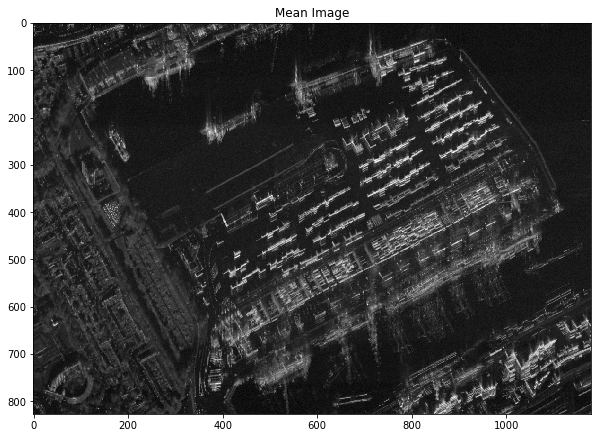

In [15]:
# uses an additional band as a counter
def myaverage(old_data, new_data, old_nodata, new_nodata, index, roff, coff):
    mask = ~new_nodata[0]
    old_data[0, mask] += new_data[0][mask]
    old_data[1, mask] += 1

if (len(features) > 0):
    datasets = []
    try:
        for ft in features:
            fid = f"tiledb://capellaspace/{ft['collection']}_{ft['id']}"
            datasets.append(rasterio.open(fid))
 
        result, _ = merge(datasets, transform_bounds(CRS.from_epsg(4326), datasets[0].crs, *BBOX),
                          nodata=0, output_count=2, dtype=np.uint64, method=myaverage)

        av = result[0] / result[1]
        equ = exposure.adjust_log(av, gain=10)
    finally:
        for ds in datasets:
            ds.close()
            
    rcParams['figure.figsize'] = 10, 10
    fig, ax = plt.subplots()
    ax.imshow(equ, cmap='gray');
    ax.set_title("Mean Image");            
else:
    print('No datasets to merge')

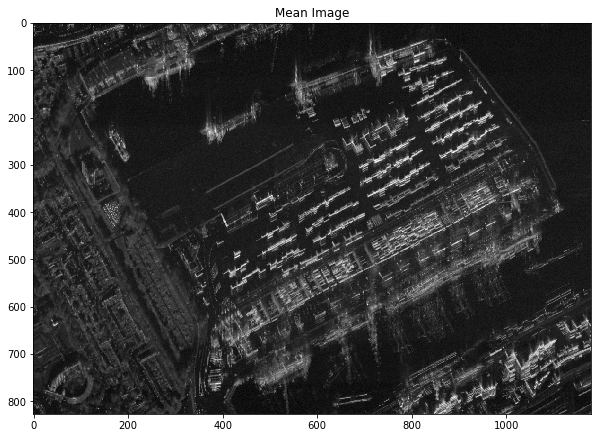

In [16]:
# stacks inputs and then computes mean across the bands
def stack_average(old_data, new_data, old_nodata, new_nodata, index, roff, coff):
    mask = ~new_nodata[0]
    old_data[index, mask] = new_data[0][mask]
    
if (len(features) > 0):
    datasets = []
    try:
        for ft in features:
            fid = f"tiledb://capellaspace/{ft['collection']}_{ft['id']}"
            datasets.append(rasterio.open(fid))
 
        output_count = len(datasets) 
        result, _ = merge(datasets, transform_bounds(CRS.from_epsg(4326), datasets[0].crs, *BBOX),
                          nodata=0, output_count=output_count, method=stack_average)
        av = result.sum(axis=0) / (result != 0).sum(axis=0)        
        equ = exposure.adjust_log(av, gain=10)
    finally:
        for ds in datasets:
            ds.close()
            
    rcParams['figure.figsize'] = 10, 10
    fig, ax = plt.subplots()
    ax.imshow(equ, cmap='gray');
    ax.set_title("Mean Image");            
else:
    print('No datasets to merge')